# Figures

In here, all the main figures are plotted

In [361]:
import numpy as np
import pandas as pd
from ridgeplot import ridgeplot

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'notebook'
from graphmodex import plotlymodex

import matplotlib.pyplot as plt
import seaborn as sns

from bumplot import bumplot

# Forecasting

In [362]:
# ===============================
# CONFIG
# ===============================
steps_per_day = 8
two_year_steps = 2 * 365 * steps_per_day
target_windows = 30

FREQ = '3h'
SEASON_LENGTH = 8 

pollutants_dict = {
        'go3': {
            'scaler': 1e8
        },
        'no2': {
            'scaler': 1e10
        },
        'pm10': {
            'scaler': 1e9
        },
        'pm2p5': {
            'scaler': 1e9
        },
    }
experiments_dict = {
    '1 days': {
        'horizon': 8*1,
        'step_size': max(8*1, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '7 days': {
        'horizon': 8*7,
        'step_size': max(8*7, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '14 days': {
        'horizon': 8*14,
        'step_size': max(8*14, two_year_steps // target_windows),
        'windows': target_windows,
    },
    '30 days': {
        'horizon': 8*30,
        'step_size': 8*30,
        'windows': two_year_steps // (8*30),  # 24
    },
}

In [363]:
database_full = pd.read_csv(r'.\Results\RQ1\full\go3_1days.csv')
database_full = database_full.query("NHITS.notna()")

In [364]:
def plot_pollutant_forecasting(
        poll='go3',
        h=1,
        uid=0,
        models={
            'NHITS': "#287eb8",
            'NBEATS-G': "#72a549",
            'NBEATS-I': "#d4bc34",
            'LightGBM': "#6c34d4",
            'Naive': "#d43f34",
            'SeasonalNaive': "#d4347f",
        },
        horizon=None  # Adicionando o parâmetro horizon
    ):

    series = pd.read_parquet(rf'.\Results\RQ1\full\{poll}.parquet')

    df = pd.read_csv(rf'.\Results\RQ1\full\{poll}_{str(h)}days.csv')
    # df = df.query("NHITS.notna()")
    df = df.rename(columns={'valid_time': 'ds'})
    df = df.astype({
        'ds': 'datetime64[ns]',
        'cutoff': 'datetime64[ns]',
    })

    cutoffs = df['cutoff'].unique() 

    # ==================================================
    # REAL SERIE
    # ==================================================
    fig = go.Figure()

    pollutant_filt = series.copy().query(
        "ds >= '2022-06-01' and unique_id == @uid"
    )

    fig.add_trace(
        go.Scatter(
            x=pollutant_filt['ds'],
            y=pollutant_filt['y'],
            mode='lines',
            line=dict(color='black', width=2),
            name='Real'
        )
    )

    # ==================================================
    # MODELS — ONE WINDOW PER CUTOFF
    # ==================================================
    for model, color in models.items():
        show_legend_ = True
        for cutoff in cutoffs:

            df_fold = df.query(
                "unique_id == @uid and cutoff == @cutoff"
            )

            if df_fold.empty:
                continue

            # Linha da previsão (segmento independente)
            fig.add_trace(
                go.Scatter(
                    x=df_fold['ds'],
                    y=df_fold[model],
                    mode='lines',
                    line=dict(color=color, width=2),
                    marker=dict(color=color, size=5),
                    opacity=0.75,
                    name=model,
                    showlegend=show_legend_
                )
            )

            show_legend_ = False

    # ==================================================
    # CUTOFFS VERTICAL LINES
    # ==================================================
    for cutoff in cutoffs:
        fig.add_vline(
            x=cutoff + pd.Timedelta(hours=3),
            line_width=1,
            line_dash="dot",
            line_color="black",
            opacity=0.5
        )
        if horizon is not None:  # Usando o horizonte fornecido como parâmetro
            fig.add_vline(
                x=cutoff + pd.Timedelta(hours=3 * horizon),
                line_width=1,
                line_dash="dot",
                line_color="black",
                opacity=0.5
            )

    # ==================================================
    # FINAL LAYOUT
    # ==================================================
    plotlymodex.main_layout(
        fig, width=1200, height=600,
        x=r"$\mathrm{time_{\ freq: 3 h}}$",
        y=r"$\mathrm{kg\ kg^{-1}}$",
        title='Pollutant Forecasting | Cross-Validation Windows'
    )

    fig.update_layout(
        legend_title_text='Series',
        hovermode='x unified',

        # Fonte global
        font=dict(
            family="Times New Roman",
            size=14,
            color="black"
        ),

        # Eixo X
        xaxis=dict(
            showgrid=False, zeroline=False,
            title_font=dict(family="Times New Roman"),
            tickfont=dict(family="Times New Roman")
        ),

        # Eixo Y
        yaxis=dict(
            zeroline=False,
            title_font=dict(family="Times New Roman"),
            tickfont=dict(family="Times New Roman")
        ),
    )

    fig.update_layout(
        # Margens bem mais compactas
        margin=dict(
            l=60,
            r=10,
            t=60, 
            b=50
        ),

        # Título mais compacto
        title=dict(
            y=0.97,
            yanchor='top'
        )
    )

    fig.update_layout(
        legend=dict(
            x=0.01,      # esquerda
            y=0.99,      # topo
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.7)',  # opcional
            bordercolor='black',              # opcional
            borderwidth=2                     # opcional
        )
    )

    return fig

In [377]:
# Exemplo de chamada da função para um dado modelo e cutoff
models = {
    'NHITS': "#287eb8",
    # 'NBEATS-G': "#72a549",
    # 'NBEATS-I': "#d4bc34",
    'LightGBM': "#6c34d4",
    # 'Naive': "#d43f34",
    # 'SeasonalNaive-56': "#d46f34",
    # 'SeasonalNaive-8': "#d4347f",
}

# Chamada da função com o ID único, cutoffs e modelos
plot_pollutant_forecasting(
    poll='go3',
    h=30,
    uid=54,
    models=models,
)

# **RQ1**

In [366]:
metrics = pd.read_csv(r'.\Results\RQ1\metrics.csv')

In [368]:
def plot_ridge_metrics(h : str = '30', metric: str = 'sMAPE', agg_func: str = 'median'):

    # ===============================
    # DATA PREPARATION
    # ===============================

    df_plot = metrics.dropna(subset=[metric])

    median_smape = (
        df_plot
        .query(f"horizon == '{h}days'")
        .groupby("model")[metric]
        .agg(agg_func)
        .sort_values()
    )

    ordered_models = median_smape.index.tolist()

    samples = [
        df_plot.loc[df_plot["model"] == m, metric].values
        for m in ordered_models
    ]

    labels = ordered_models


    # ===============================
    # RIDGEPLOT
    # ===============================

    fig = ridgeplot(samples=samples, labels=labels)

    for tr in fig.data:
        tr.showlegend = False

    plotlymodex.main_layout(
        fig,
        title=f"Distribution of {h}-Day-Ahead {metric} by Model (Ordered by {agg_func.capitalize()} Performance)",
        width=1000,
        height=700,
        x=f"{metric}↓",
        y=None
    )

    fig.update_layout(font=dict(family="Times New Roman", size=16))


    # ===============================
    # CUSTOM Y-AXIS LABELS
    # ===============================

    yvals = list(fig.layout.yaxis.tickvals)

    fig.update_yaxes(showticklabels=False)

    NAME_SHIFT = 0
    MU_SHIFT = -15

    for y, m in zip(yvals, ordered_models):

        fig.add_annotation(
            xref="paper",
            x=0, yref="y",
            y=y, text=f"{m}  ",
            showarrow=False,
            xanchor="right",
            align="right",
            font=dict(family="Times New Roman", size=16),
            yshift=NAME_SHIFT
        )

        fig.add_annotation(
            xref="paper",
            x=0, yref="y",
            y=y, text=f"{agg_func.capitalize()} = {median_smape[m]:.3f}  ",
            showarrow=False,
            xanchor="right",
            align="right",
            font=dict(family="Times New Roman", size=12),
            yshift=MU_SHIFT
        )

    fig.update_layout(
        margin=dict(l=140, r=40, t=50, b=60),
        title=dict(y=0.97, yanchor="top")
    )


    # ===============================
    # MODEL FAMILIES
    # ===============================

    neural_models = ["NBEATS-I", "NBEATS-G", "NHITS"]
    ml_models = ["LightGBM"]
    stat_models = ["Arima", "ETS", "Theta"]
    benchmark_models = ["Naive", "SeasonalNaive-8", "SeasonalNaive-56"]


    # ===============================
    # COLOR GRADIENT MAP
    # ===============================

    family_gradients = {
        "neural": ["#D62121", "#ECD449", "#ECD449"],
        "ml": ["#00B17A", "#3676AA", "#6D2DA8"],
        "stat": ["#BD5CE4", "#38C4DD", "#38C4DD"],
        "benchmark": ["#707070", "#E7E7E7", "#E7E7E7"]
    }


    # ===============================
    # FAMILY IDENTIFICATION
    # ===============================

    def get_family(model):
        if model in neural_models:
            return "neural"
        elif model in ml_models:
            return "ml"
        elif model in stat_models:
            return "stat"
        elif model in benchmark_models:
            return "benchmark"
        else:
            return None


    def build_colorscale(anchor_colors):
        colors = plotlymodex.list_colors(
            n=20,
            colors=anchor_colors,
            weights=[0, 0.5, 1]
        )
        return [[i/(len(colors)-1), c] for i, c in enumerate(colors)]


    # ===============================
    # APPLY GRADIENTS
    # ===============================

    for trace in fig.data:

        if trace.fill == "tonexty":

            model = trace.name
            family = get_family(model)

            if family is not None:

                anchors = family_gradients[family]

                trace.fillgradient = dict(
                    type="horizontal",
                    colorscale=build_colorscale(anchors)
                )

    fig.update_xaxes(
        showgrid=True,
        gridwidth=0.4,
        gridcolor="rgba(0,0,0,0.07)"
    )
    fig.update_xaxes(range=[0, 1.5])
    fig.update_yaxes(showgrid=False)

    for trace in fig.data:
        trace.line.width = 1

    fig.show()

In [369]:
plot_ridge_metrics(h=1, metric='sMAPE', agg_func='median')
plot_ridge_metrics(h=7, metric='sMAPE', agg_func='median')
plot_ridge_metrics(h=14, metric='sMAPE', agg_func='median')
plot_ridge_metrics(h=30, metric='sMAPE', agg_func='median')

In [370]:
def plot_bump_all_pollutants(metrics, pollutants, metric="MAE", agg_func: str = 'mean'):

    plt.rcParams.update({
        "font.family": "Times New Roman",
        "font.size": 12
    })

    model_category = {
        'NHITS': 'Neural',
        'NBEATS-I': 'Neural',
        'NBEATS-G': 'Neural',
        'LightGBM': 'ML',
        'Theta': 'Stats',
        'Arima': 'Stats',
        'ETS': 'Stats',
        'Naive': 'Benchmark',
        'SeasonalNaive-8': 'Benchmark',
        'SeasonalNaive-56': 'Benchmark'
    }

    color_map = {
        'Neural': '#F28E2B',
        'ML': '#2CA02C',
        'Stats': '#4DBBD5',
        'Benchmark': '#9E9E9E',
        'Other': '#000000'
    }

    category_markers = ['o', 's', 'X']

    # ==============================
    # PREPARE DATA (once)
    # ==============================

    df = (
        metrics
        .groupby(["pollutant", "horizon", "model"], observed=False)[metric]
        .agg(agg_func)
        .reset_index()
    )

    df["horizon"] = df["horizon"].str.replace("days", "", regex=False)
    df["horizon"] = df["horizon"].astype(int)

    horizons = sorted(df["horizon"].unique())
    horizon_labels = [f"{h}d" for h in horizons]
    x_numeric = np.arange(len(horizons))

    # ==============================
    # CREATE SUBPLOTS
    # ==============================

    fig, axes = plt.subplots(2, 2, figsize=(11, 9), sharey=True)
    axes = axes.flatten()

    handles = []
    labels = []

    for ax, pollutant in zip(axes, pollutants):

        pollutant_display = {
            "no2": r"NO$_2$",
            "pm10": r"PM$_{10}$",
            "pm2p5": r"PM$_{2.5}$",
            "go3": r"O$_{3}$",
        }

        df_pol = df[df["pollutant"] == pollutant].copy()
        df_pol = df_pol.sort_values("horizon")

        df_pol["rank"] = (
            df_pol
            .groupby("horizon", observed=False)[metric]
            .rank(method="average", ascending=True)
        )

        df_bump = (
            df_pol[["model", "horizon", "rank"]]
            .pivot(index="horizon", columns="model", values="rank")
            .reindex(horizons)
        )

        models = df_bump.columns.tolist()
        category_counter = {}

        for model in models:

            category = model_category.get(model, "Other")
            color = color_map.get(category, "#000000")

            if category not in category_counter:
                category_counter[category] = 0

            marker = category_markers[
                category_counter[category] % len(category_markers)
            ]
            category_counter[category] += 1

            y = df_bump[model].values

            line, = ax.plot(
                x_numeric,
                y,
                label=model,
                color=color,
                linewidth=2.5,
                marker=marker,
                markersize=12,
                markeredgecolor="black",
                markeredgewidth=0.8
            )

            # capture legend only once
            if pollutant == pollutants[0]:
                handles.append(line)
                labels.append(model)

        ax.set_title(pollutant_display.get(pollutant, pollutant.upper()))

        ax.set_xticks(x_numeric)
        ax.set_xticklabels(horizon_labels)
        ax.invert_yaxis()
        ax.grid(alpha=0.25)
        ax.spines[["top", "right"]].set_visible(False)

    max_rank = int(
        df.groupby(["pollutant", "horizon"], observed=False)[metric]
        .rank(method="average", ascending=True)
        .max()
    )
    for ax in axes:
        ax.set_ylim(max_rank + 0.5, 0.5)  # força 1 no topo
        ax.set_yticks(range(1, max_rank + 1))

    axes[0].set_ylabel("Rank (1 = Best)")
    axes[2].set_ylabel("Rank (1 = Best)")
    
    # Define ordem desejada das categorias
    category_order = {
        "Neural": 0,
        "ML": 1,
        "Stats": 2,
        "Benchmark": 3,
        "Other": 4
    }

    # Cria lista combinada
    legend_items = list(zip(handles, labels))

    # Ordena baseado na categoria do modelo
    legend_items.sort(
        key=lambda x: category_order.get(model_category.get(x[1], "Other"), 4)
    )

    # Separa novamente
    handles_sorted, labels_sorted = zip(*legend_items)

    fig.legend(
        handles_sorted,
        labels_sorted,
        title="Model",
        bbox_to_anchor=(0.91, 0.5),
        loc="center left",
        frameon=False
    )

    fig.suptitle(
        f"Model Ranking Across Pollutants Based on {metric} {agg_func.capitalize()}",
        fontsize=16,
        y=0.98
    )

    plt.tight_layout(rect=[0, 0, 0.92, 1])
    plt.show()

    return fig, axes

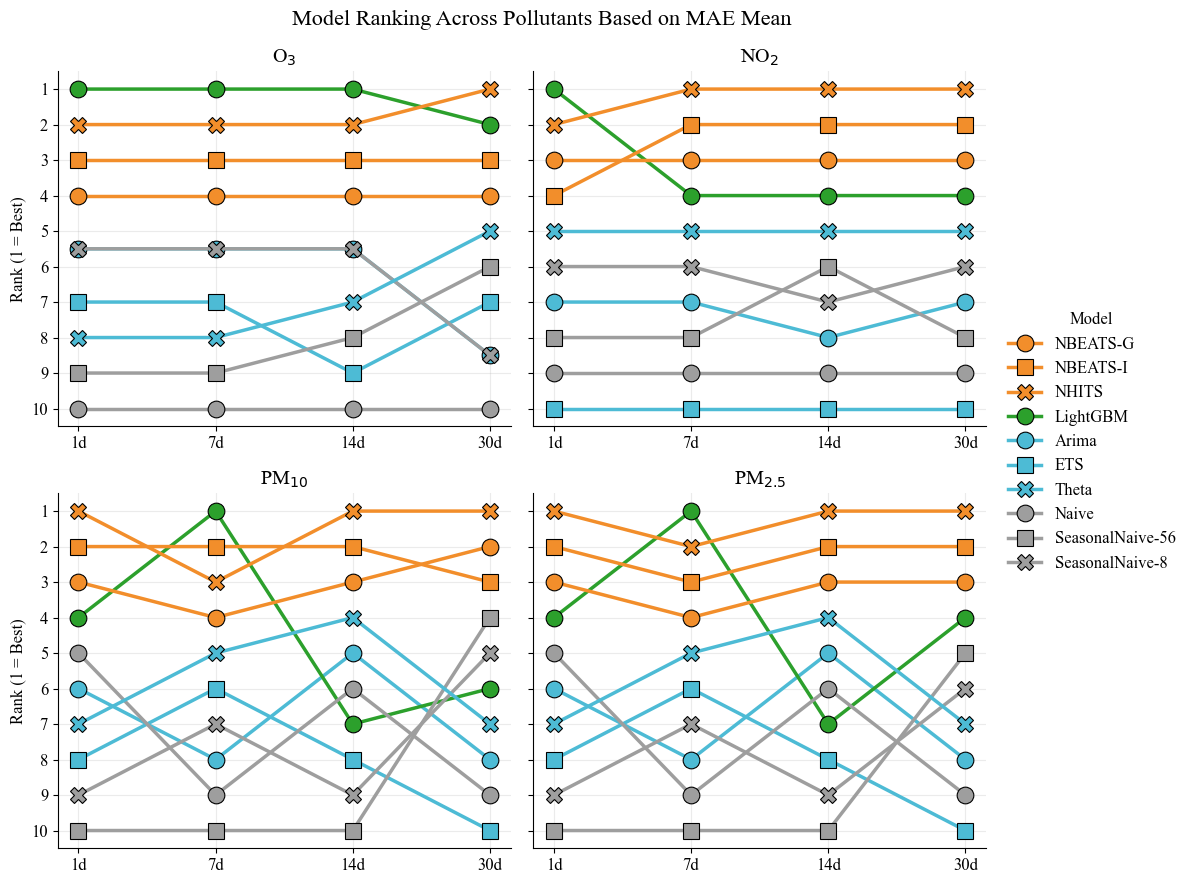

In [371]:
plot_bump_all_pollutants(
    metrics,
    pollutants=["go3", "no2", "pm10", "pm2p5"],
    metric="MAE", 
    agg_func='mean'
);

# **RQ2**